# Lab 2, Classification

# Group 1, Ben Goodwin and Andre Mauldin

# Resubmission Summary

## Data Preperation Part I

This section is unchanged


## Data Preperation Part II

This section is unchanged


## Modeling and Evaluation I

This section is unchanged

## Modeling and Evaluation II

This section was completely re-worked based on the feedback from the first submission.  The outline of this section was completed to include details on our chosen CV metric for both our classification task and our regression task.  We informed the reader of the validation metrics as well as how we aim to interpret and evaluate our model performance.  In terms of actual coding, we used this section to include CV code matching our chosen method.  This CV code is now referenced throughout the document and becuause of these changes our code is more consistent and human readable.  

## Modeling and Evaluation III

Section modifed heavily to match project specifications.  Section is broken into two main parts, the first part creates three different regression models for each task.  The models are: LASSO, Ridge, and Elastic net.  The second part creates three different classification models for each task.  Those models are: KNN, Random Forest, and Gaussian Navie Bayes.  

We addressed the issue of matching CV seed not matching the part from modeling and evaluation II.  Each regression and classification model refrences the CV seed set in the prior section.  This makes the results consistent and reproducable.  

"CappedLinearRegression" was removed, it makes no sense to clip all delay times.  

Results and tuning from the models have been restructured and are clearly indicated.  

Gridseach has been fixed to qualify for paramter tuning and the widgets are correctly working and can be adjusted based on user input.  

"EvaluateRegressionEstimator" is now correctly implemented and displays results for each model.  

I spent a long period of time adjusting and reworking this section, and the results are now accurately displayed.  I believe since Andre submitted the original file, he did not have the correct libraries installed to run widgets and caused many of our results to not appear, I apologize for this and have fixed those issues.

## Modeling and Evaluation IV

Section completely re-done to fit feedback and project specifications.  Like prior sections this is broken into two distinct parts, the first being related to the regression task and the second is related to the classification task.  Within modeling and evaluation two, we built the models and gave each model the ability to have it's paramters adjusted, and we learned which paramter adjustments led to the best model performance.  These paramters and models were brought into modeling and evaluation IV for analysis and comparison.  Each model was visualized (regression task displayed a table of CV results and different metrics (MSE, RMSE, MAPE) and classification task displayed plots of within class accuracy (displaying how each algorithm correctly classfied on-time and not-on-time flights.  I explained why each model was useful and disucssed trade offs between performance and accuracy.  The best performing regression model was LASSO with a MSE of around 40.0, and the best performing classification algorithm was random forest with an accuracy around 72% (this did NOT meet our metric for success (that was 0.8).  But we explained that despite this fact, the models were still much better than randomly guessing if a flight was delayed on arrival or not.  

## Modeling and Evaluation V

## Modeling and Evaluation VI

## Deployment 

This section is unchanged





In this analysis we will build upon the mini project and add additional modeling from new classification techniques.

We will classify if a given flight will have an on time arrival or not

We will regress the arrival delay length given a delay type, operating airline, origin airport, and month.  


# Data Preperation Part I

In this section we define and prepare our class varaibles, we one-hot encoded operating carrier, origin, and month.  We also changed the time information into properly represented time objects.  As we embded varaibles into others we remove the unnecessary variables.  We also scaled the varaibles.  

In [1]:
#import libraries
from __future__ import print_function
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from ipywidgets import widgets as wd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Read in the flight delay data
#Our data is from Department of transportation
#https://www.bts.gov/topics/airlines-and-airports/number-14-time-reporting
df = pd.read_csv('2018.csv') # read in the csv file
#df.info()

#We will create two datasets from this original file (one for classification and one for regression)
#Reduce dataset to a more manageable size.
#We randomly sampled 150,000 records.  This is a reasonable sample size that will not cause excessively long computation times
dfReduced=df.sample(n=150000, random_state=1)
dfReduced2=df.sample(n=500000,random_state=3)

### Cleaning up the Data

Next, we create an array of each type of delay. This will be helpful as we will need to handle the missing values for the delays.

In [2]:
#Remove attributes that just arent useful for us
#Each of these variables removed is either of no use or can be derived using other variables in dataset. 
#Logistic regression dataframe
del dfReduced['DIVERTED']
#del dfReduced['DISTANCE']
del dfReduced['TAXI_OUT']
del dfReduced['TAXI_IN']
del dfReduced['Unnamed: 27']
del dfReduced['CANCELLED']
del dfReduced['CANCELLATION_CODE']
del dfReduced['DEST']
del dfReduced['OP_CARRIER_FL_NUM']
del dfReduced['WHEELS_ON']
del dfReduced['DEP_TIME']
del dfReduced['WHEELS_OFF']
#del dfReduced['CRS_DEP_TIME']

#Linear Regression Data frame
del dfReduced2['DIVERTED']
del dfReduced2['DISTANCE']
del dfReduced2['TAXI_OUT']
del dfReduced2['TAXI_IN']
del dfReduced2['Unnamed: 27']
del dfReduced2['CANCELLED']
del dfReduced2['CANCELLATION_CODE']
del dfReduced2['DEST']
del dfReduced2['OP_CARRIER_FL_NUM']
del dfReduced2['WHEELS_ON']
del dfReduced2['DEP_TIME']
del dfReduced2['WHEELS_OFF']
#del dfReduced2['CRS_DEP_TIME']



#Bring all delay types into one variable "delayArr"

delayArr = [
    'DEP_DELAY'
    ,'ARR_DELAY'
    ,'CARRIER_DELAY'
    ,'WEATHER_DELAY'
    ,'NAS_DELAY'
    ,'SECURITY_DELAY'
    ,'LATE_AIRCRAFT_DELAY'
]
#LR df
dfReduced[delayArr].describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific
#Reg df
dfReduced2[delayArr].describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific

,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,491811.00000,490477.00000,93509.00000,93509.00000,93509.00000,93509.00000,93509.00000
mean,9.92004,4.95151,19.41729,3.67115,15.84077,0.08282,25.50798
std,44.99009,47.04811,58.55557,30.83027,36.46026,2.34391,50.18457
min,-112.00000,-108.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,-5.00000,-14.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,-2.00000,-6.00000,0.00000,0.00000,3.00000,0.00000,2.00000
75%,7.00000,8.00000,17.00000,0.00000,20.00000,0.00000,31.00000
max,2468.00000,2454.00000,1510.00000,1352.00000,1491.00000,297.00000,2454.00000


In [3]:
#Here we take the date of the flight and place it into a month so that we can investiage seasonal trends and create our
#outcome variable of "ON_TIME_ARRIVAL."  This is what we will be predicting
#LR model
dfReduced['MONTH'] = dfReduced['FL_DATE'].str[5:7]
conditions = [
    (dfReduced['CRS_ARR_TIME'] >= dfReduced['ARR_TIME']),
    (dfReduced['CRS_ARR_TIME'] < dfReduced['ARR_TIME'])]
choices = [1, 0]

dfReduced['ON_TIME_ARRIVAL'] = np.select(conditions, choices, default='null')

#Reg model
dfReduced2['MONTH'] = dfReduced2['FL_DATE'].str[5:7]
conditions = [
    (dfReduced2['CRS_ARR_TIME'] >= dfReduced2['ARR_TIME']),
    (dfReduced2['CRS_ARR_TIME'] < dfReduced2['ARR_TIME'])]
choices = [1, 0]

dfReduced2['ON_TIME_ARRIVAL'] = np.select(conditions, choices, default='null')

We are dropping rows that are NA for arrival time, expected arrival time, actual elapsed time, and air time. We are only interested in flights that arrived at their destination.

Arrival time is needed to calculate OTA in order to train the model. ACTUAL_ELAPSED_TIME and AIR_TIME are related to the how long it took to flight to arrive at it's destination. We drop the NAs because only flights that actually arrive will have a value.

For our delay variables, we set the NAs to 0.0, meaning there was no delay.  The previous value wa NaN which can't be calculated using logistic regression.

In [4]:
# We are only interested in flights that actually arrived.
# NAs are very few for these columns.  We will drop them.
# LR model
dfReduced = dfReduced.dropna(subset=['ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

# Set NaN values to 0.0 to show zero minutes for delay time. Used array and for loop to avoid repetetive code

def replaceNaN(data, arr):
    for delayType in arr:
        data[delayType] = data[delayType].fillna(0.0)
    return data

dfReduced = replaceNaN(dfReduced, delayArr)

#Reg Model
dfReduced2 = dfReduced2.dropna(subset=['ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

# Set NaN values to 0.0 to show zero minutes for delay time. Used array and for loop to avoid repetetive code

def replaceNaN(data, arr):
    for delayType in arr:
        data[delayType] = data[delayType].fillna(0.0)
    return data

dfReduced2 = replaceNaN(dfReduced2, delayArr)



In [5]:
#Now that we have month, lets get rid of FL_DATE as the information is captured
#LR model
del dfReduced['FL_DATE']
#Lets reduce to top 10 airports by passengers for 2018
#https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States#Busiest_U.S._airports_by_total_passenger_traffic_(2018)
dfReduced=dfReduced[dfReduced.ORIGIN.eq("ATL")| dfReduced.ORIGIN.eq("LAX")| dfReduced.ORIGIN.eq("ORD")| dfReduced.ORIGIN.eq("DFW")| dfReduced.ORIGIN.eq("DEN")| dfReduced.ORIGIN.eq("JFK")| dfReduced.ORIGIN.eq("SFO")| dfReduced.ORIGIN.eq("SEA")| dfReduced.ORIGIN.eq("LAS")| dfReduced.ORIGIN.eq("MCO")]
#print(dfReduced)
dfReduced[['OP_CARRIER','ORIGIN','MONTH','ON_TIME_ARRIVAL']].describe().transpose()

#Make sure datatypes for all variables are good to go
dfReduced.info()

#Reg model
del dfReduced2['FL_DATE']
#Lets reduce to top 10 airports by passengers for 2018
#https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States#Busiest_U.S._airports_by_total_passenger_traffic_(2018)
dfReduced2=dfReduced2[dfReduced2.ORIGIN.eq("ATL")| dfReduced2.ORIGIN.eq("LAX")| dfReduced2.ORIGIN.eq("ORD")| dfReduced2.ORIGIN.eq("DFW")| dfReduced2.ORIGIN.eq("DEN")| dfReduced2.ORIGIN.eq("JFK")| dfReduced2.ORIGIN.eq("SFO")| dfReduced2.ORIGIN.eq("SEA")| dfReduced2.ORIGIN.eq("LAS")| dfReduced2.ORIGIN.eq("MCO")]
#print(dfReduced)
dfReduced2[['OP_CARRIER','ORIGIN','MONTH','ON_TIME_ARRIVAL']].describe().transpose()

#Make sure datatypes for all variables are good to go
dfReduced2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45284 entries, 929508 to 6830663
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OP_CARRIER           45284 non-null  object 
 1   ORIGIN               45284 non-null  object 
 2   CRS_DEP_TIME         45284 non-null  int64  
 3   DEP_DELAY            45284 non-null  float64
 4   CRS_ARR_TIME         45284 non-null  int64  
 5   ARR_TIME             45284 non-null  float64
 6   ARR_DELAY            45284 non-null  float64
 7   CRS_ELAPSED_TIME     45284 non-null  float64
 8   ACTUAL_ELAPSED_TIME  45284 non-null  float64
 9   AIR_TIME             45284 non-null  float64
 10  DISTANCE             45284 non-null  float64
 11  CARRIER_DELAY        45284 non-null  float64
 12  WEATHER_DELAY        45284 non-null  float64
 13  NAS_DELAY            45284 non-null  float64
 14  SECURITY_DELAY       45284 non-null  float64
 15  LATE_AIRCRAFT_DELAY  45284 no

### Perform One-Hot encoding of categorical data

#### Remove other unused variables

#### Also remove variables that are captured in other variables

In [6]:
dfReduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45284 entries, 929508 to 6830663
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OP_CARRIER           45284 non-null  object 
 1   ORIGIN               45284 non-null  object 
 2   CRS_DEP_TIME         45284 non-null  int64  
 3   DEP_DELAY            45284 non-null  float64
 4   CRS_ARR_TIME         45284 non-null  int64  
 5   ARR_TIME             45284 non-null  float64
 6   ARR_DELAY            45284 non-null  float64
 7   CRS_ELAPSED_TIME     45284 non-null  float64
 8   ACTUAL_ELAPSED_TIME  45284 non-null  float64
 9   AIR_TIME             45284 non-null  float64
 10  DISTANCE             45284 non-null  float64
 11  CARRIER_DELAY        45284 non-null  float64
 12  WEATHER_DELAY        45284 non-null  float64
 13  NAS_DELAY            45284 non-null  float64
 14  SECURITY_DELAY       45284 non-null  float64
 15  LATE_AIRCRAFT_DELAY  45284 no

In [7]:
#LR model
# perform one-hot encoding of the categorical data "OP_CARRIER"
tmp_df = pd.get_dummies(dfReduced.OP_CARRIER,prefix="Operating Carrier")
dfReduced = pd.concat((dfReduced,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "ORIGIN"
tmp_df = pd.get_dummies(dfReduced.ORIGIN,prefix="Origin")
dfReduced = pd.concat((dfReduced,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(dfReduced.MONTH,prefix="Month")
dfReduced = pd.concat((dfReduced,tmp_df),axis=1)


#Kill variables we hot-encoded
del dfReduced['OP_CARRIER']
del dfReduced['ORIGIN']
del dfReduced['MONTH']

#Create new DF for Regression Problem
#If a flight is delayed, which delay type produces long delays?
dfReg = dfReduced.copy()

#Kill Varibles we no longer need because they are encoded in ON_TIME_ARRIVAL
del dfReduced['ARR_TIME']
del dfReduced['CRS_ARR_TIME']
del dfReduced['CRS_ELAPSED_TIME']

#Drop Arr_delay, because this is essentially a proxy for 'ON_TIME_ARRIVAL'
del dfReduced['ARR_DELAY']

dfReduced.info()


#Reg model
# perform one-hot encoding of the categorical data "OP_CARRIER"
tmp_df = pd.get_dummies(dfReduced2.OP_CARRIER,prefix="Operating Carrier")
dfReduced2 = pd.concat((dfReduced2,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "ORIGIN"
tmp_df = pd.get_dummies(dfReduced2.ORIGIN,prefix="Origin")
dfReduced2 = pd.concat((dfReduced2,tmp_df),axis=1)

# perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(dfReduced2.MONTH,prefix="Month")
dfReduced2 = pd.concat((dfReduced2,tmp_df),axis=1)


#Kill variables we hot-encoded
del dfReduced2['OP_CARRIER']
del dfReduced2['ORIGIN']
del dfReduced2['MONTH']

#Create new DF for Regression Problem
#If a flight is delayed, which delay type produces long delays?
dfReg = dfReduced2.copy()

#Kill Varibles we no longer need because they are encoded in ON_TIME_ARRIVAL
del dfReduced2['CRS_ELAPSED_TIME']

#Drop Arr_delay, because this is essentially a proxy for 'ON_TIME_ARRIVAL'
del dfReduced2['ARR_DELAY']

dfReduced2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45284 entries, 929508 to 6830663
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CRS_DEP_TIME          45284 non-null  int64  
 1   DEP_DELAY             45284 non-null  float64
 2   ACTUAL_ELAPSED_TIME   45284 non-null  float64
 3   AIR_TIME              45284 non-null  float64
 4   DISTANCE              45284 non-null  float64
 5   CARRIER_DELAY         45284 non-null  float64
 6   WEATHER_DELAY         45284 non-null  float64
 7   NAS_DELAY             45284 non-null  float64
 8   SECURITY_DELAY        45284 non-null  float64
 9   LATE_AIRCRAFT_DELAY   45284 non-null  float64
 10  ON_TIME_ARRIVAL       45284 non-null  object 
 11  Operating Carrier_9E  45284 non-null  uint8  
 12  Operating Carrier_AA  45284 non-null  uint8  
 13  Operating Carrier_AS  45284 non-null  uint8  
 14  Operating Carrier_B6  45284 non-null  uint8  
 15  Operating Ca

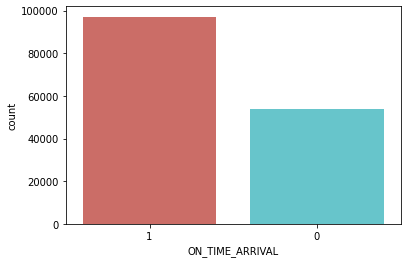

In [8]:
#Investigate suitability of data for logistic regression
#This data is quite imblanaced and could result in reasonably high classifcation by just assuming flights arrive on time.
#This will need to be fixed. We correct this a few sections down, but its important to visualize now. 
import seaborn as sns
#LR Model
dfReduced['ON_TIME_ARRIVAL'].value_counts()

sns.countplot(x='ON_TIME_ARRIVAL',data=dfReduced,palette='hls')

#This section scales the variables to values between 0 and 1 in order to get the data ready for logistic regression.
#We only scale variables that aren't already between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# Scale only columns that have values greater than 1
mms = MinMaxScaler()
dfScaled=dfReduced
dfScaled[["DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]] = mms.fit_transform(dfScaled[["DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]])


#Reg Model
dfReduced2['ON_TIME_ARRIVAL'].value_counts()

sns.countplot(x='ON_TIME_ARRIVAL',data=dfReduced2,palette='hls')

#This section scales the variables to values between 0 and 1 in order to get the data ready for logistic regression.
#We only scale variables that aren't already between 0 and 1


# Scale only columns that have values greater than 1
mms2 = MinMaxScaler()
dfScaled2=dfReduced2
dfScaled2[["DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]] = mms2.fit_transform(dfScaled2[["DEP_DELAY","ACTUAL_ELAPSED_TIME","AIR_TIME","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY",
          "SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]])

In [9]:
del dfReduced['DEP_DELAY']
del dfReduced['CARRIER_DELAY']
del dfReduced['WEATHER_DELAY']
del dfReduced['NAS_DELAY']
del dfReduced['SECURITY_DELAY']
del dfReduced['LATE_AIRCRAFT_DELAY']

#### Data Preperation for Regression

In [10]:
#Drops all flights that arrived early or on time.  We are only interested in delays.

#dfReduced2.info()
dfReduced2.drop(dfReduced2[dfReduced2['ARR_TIME']-dfReduced2['CRS_ARR_TIME']<=0].index, inplace = True)

In [11]:
#We have times in our data, but need to be converted to date/time objects.
import datetime
dfScaled2['ARR_TIME']=dfScaled2['ARR_TIME'].astype(int)
dfScaled2['ARR_TIME']=dfScaled2['ARR_TIME'].round()
dfScaled2['ARR_STRING']=dfScaled2['ARR_TIME'].apply(str)

dfScaled2['ARR_STRING']=dfScaled2['ARR_STRING'].str.pad(width=4,side='left',fillchar='0')
time=(dfScaled2.assign(newtime=pd.to_datetime(dfScaled2['ARR_STRING'],format='%H%M',errors='coerce')))

time['newtime'] = time['newtime'].astype('datetime64')
#time['newtime'] = time['newtime'].dt.strftime('%H:%M')


###################################################################################################


dfScaled2['CRS_ARR_TIME']=dfScaled2['CRS_ARR_TIME'].astype(int)
dfScaled2['CRS_ARR_TIME']=dfScaled2['CRS_ARR_TIME'].round()
dfScaled2['CRS_ARR_STRING']=dfScaled2['CRS_ARR_TIME'].apply(str)


dfScaled2['CRS_ARR_STRING']=dfScaled2['CRS_ARR_STRING'].str.pad(width=4,side='left',fillchar='0')
time1=(dfScaled2.assign(CRSnewtime=pd.to_datetime(dfScaled2['CRS_ARR_STRING'],format='%H%M',errors='coerce')))
#time['CRSnewtime'] = time['CRSnewtime'].dt.strftime('%H:%M')
time1['CRSnewtime'] = time1['CRSnewtime'].astype('datetime64')


#Add 'CRS_ARR_TIME' to df
time['CRSnewtime']=time1['CRSnewtime']

#Kill Varibles we no longer need because we now have properly encoded times
del time['CRS_ARR_TIME']
del time['ARR_TIME']
del time['ARR_STRING']
del time['CRS_DEP_TIME']

#Create delay time variable
time['delayTimeDate'] = (time['newtime']-time['CRSnewtime'])

In [12]:
time['LATE_AIRCRAFT_DELAY'] = np.where(time['LATE_AIRCRAFT_DELAY']>0,1,0)
time['CARRIER_DELAY'] = np.where(time['CARRIER_DELAY']>0,1,0)
time['WEATHER_DELAY'] = np.where(time['WEATHER_DELAY']>0,1,0)
time['SECURITY_DELAY'] = np.where(time['SECURITY_DELAY']>0,1,0)
time['LATE_AIRCRAFT_DELAY'] = np.where(time['LATE_AIRCRAFT_DELAY']>0,1,0)
time['NAS_DELAY'] = np.where(time['NAS_DELAY']>0,1,0)


time['SECURITY_DELAY']=time['SECURITY_DELAY'].astype(int)


In [13]:
time['LATE_AIRCRAFT_DELAY']= time['LATE_AIRCRAFT_DELAY'].astype('category')
time['CARRIER_DELAY']= time['CARRIER_DELAY'].astype('category')
time['WEATHER_DELAY']= time['WEATHER_DELAY'].astype('category')
time['SECURITY_DELAY']= time['SECURITY_DELAY'].astype('category')
time['LATE_AIRCRAFT_DELAY']= time['LATE_AIRCRAFT_DELAY'].astype('category')
time['NAS_DELAY']= time['NAS_DELAY'].astype('category')

## Final data frames for analysis. 

In [14]:
#Logistic Regression Data frame
dfScaled.info()

#Linear Regression Data frame
time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45284 entries, 929508 to 6830663
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CRS_DEP_TIME          45284 non-null  int64  
 1   ACTUAL_ELAPSED_TIME   45284 non-null  float64
 2   AIR_TIME              45284 non-null  float64
 3   DISTANCE              45284 non-null  float64
 4   ON_TIME_ARRIVAL       45284 non-null  object 
 5   Operating Carrier_9E  45284 non-null  uint8  
 6   Operating Carrier_AA  45284 non-null  uint8  
 7   Operating Carrier_AS  45284 non-null  uint8  
 8   Operating Carrier_B6  45284 non-null  uint8  
 9   Operating Carrier_DL  45284 non-null  uint8  
 10  Operating Carrier_EV  45284 non-null  uint8  
 11  Operating Carrier_F9  45284 non-null  uint8  
 12  Operating Carrier_G4  45284 non-null  uint8  
 13  Operating Carrier_HA  45284 non-null  uint8  
 14  Operating Carrier_MQ  45284 non-null  uint8  
 15  Operating Ca

# Data Preperation Part II

In this section we will describe in detail each of our variables, both variables that were included in the dataset and varaibles that we derived based on other variables.

**Note** All of our varaibles have been scaled.  We will explain these variables as they were originally intended in this section of the analysis.  (ie, we will explain the significance of each of these in their original scale) 

#### DEP_DELAY
This is a float64 variable that contains a floating-point representation of the length of time in minutes that a flight was delayed.  For example 181.0 indicates that a flight left 181 minutes after its CRS (Computer reservation system) departure time.  

#### ACTUAL_ELAPSED_TIME
This is a float64 variable that contains a floating-point representation of the measure of time in minutes of a flight.  This is gate-to-gate time (meaning the timer on this starts once the airplane leaves departure the gate, and stops when the plane arrives at its destination gate.  Many other variables are captured in this window (wheels-on, wheels-off etc). This variable is used to capture total length.  

#### AIR_TIME
This is a float64 variable that contains a floating-point representation of the measure of time in minutes of a flight after the flight leaves the ground and measures until it touches down at the destination airport.  This is a useful measure of how long a flight takes minus the activities on the ground.  This variable also helps in determining ground delays.  


#### DISTANCE
This is a float64 variable that contains a floating-point representation of the distance in miles from the origin to the desination.  This is the distance between airports in miles.  FLights with further distances are associated with longer flight times.  



#### CARRIER_DELAY
This is a categorical variable that indicates if the delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).

#### WEATHER_DELAY
This is a categorical variable that indicates if the delay was due to inclement weather.

#### NAS_DELAY
This is a categotial variable that indicates if they delay was due to the national air system.  An exmaple of this would be if NYC's airspace was congested and departing flights were held at their origin to wait until air space was cleared. 

#### SECURITY DELAY
This is a categorical variable that indicates if the delay was due to a security issue.  This could be a departing flight that requires additional screening of passengers or cargo.

#### LATE_AIRCRAFT_DELAY
This is a categorical variable that indicates if the delay was due to the inbound aircaft arriving late. 

#### ON_TIME_ARRIVAL
This is an indicator variable that is a binary outcome variable.  This variable was derived from ACTUAL_ELAPSED_TIME and AIR_TIME to determine if a flight arrived on time. This variable is used as the outcome variable for the classification task.   


#### Operating Carriers
Operating carrier has been one-hot encoded.  This is the operating airline of the flight

AirTran, Alaska, America West, American, American Eagle, Atlantic Southeast, Comair, Continental, Delta, ExpressJet Airlines, Continental Express, Frontier, JetBlue, Mesa Airlines, Northwest,Northwest Airlink SkyWest, Southwest, United, US Airways.  


#### ORIGIN
This is a one-hot encoded variable.  This is the origin airport of the flight.
Atlanta, Denver, Dallas-Fort Worth, John F Kennedy, Las Vegas, Los Angeles, Orlando, Chicago O'hare, Seattle, San Francisco. 

#### MONTH
This is a one-hot encoded variable.
This is a variable that we derived from other variables to condense the date information and investigate seasonal trends.  The months are January-December (01=January,12=December).  We derived this from FLIGHT_DATE
The variables 


#### newtime

newtime is a datetime coded object.  This is the arrival time of the flight and is derived from ARR_TIME

#### CRSnewtime

CRSnew time is a datetime coded object.  This is the CRS schedulded arrival time of the flight and is derived from CRS_ARR_TIME.

#### delayTimeDate
delayTimeDate is a datetime coded object.  This is the length of the arrival delay.  This variable is derived from the difference between arrival time (newtime) and the schedulded arrival time (CRSnewtime).  This is the variable of interest (outcome) for the regression task. 






In [15]:
#time df is df for regression
time.info()
#dfreduced is df for classification
dfReduced.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 53735 entries, 1877111 to 2446952
Data columns (total 52 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   DEP_DELAY             53735 non-null  float64        
 1   ACTUAL_ELAPSED_TIME   53735 non-null  float64        
 2   AIR_TIME              53735 non-null  float64        
 3   CARRIER_DELAY         53735 non-null  category       
 4   WEATHER_DELAY         53735 non-null  category       
 5   NAS_DELAY             53735 non-null  category       
 6   SECURITY_DELAY        53735 non-null  category       
 7   LATE_AIRCRAFT_DELAY   53735 non-null  category       
 8   ON_TIME_ARRIVAL       53735 non-null  object         
 9   Operating Carrier_9E  53735 non-null  uint8          
 10  Operating Carrier_AA  53735 non-null  uint8          
 11  Operating Carrier_AS  53735 non-null  uint8          
 12  Operating Carrier_B6  53735 non-null  uint8         

# Modeling and Evaluation 1


#### Regression 

The following evaluation metrics will be used for the regression task.
    -Mean Absolute Error (MAE)
    -Root Mean Squared Error (RMSE)
    -Mean Absolute Percentage Error (MAPE) 
    
Mean absolute error is being used because it is an intuitive metric that simply looks at the absolute difference between the data and the models preditions.  This metric is a good first pass at evaluating a models performance, its simple and quick.  The mean absolute error howeer, does not indicate under/over performance in the model.  The residuals all contribute proportionally, so larger errors will contribute significantally to the model.  A small MAE is a good indicator of good prediction and a large MAE indicates the model may need more work.  MAE of 0 is ideal, but not really possible. The MAE is farily robust to outliers since it uses the absolute value.  For this model a lower MAE is "better."  This metric is appropriate since we are concerned with the models ability to predict delay times.


Root mean squared error is the standard deviation of the residuals (commonly known as prediction errrors).  We use these rediuals to see how far from the line the points are.  RMSE is a good metric to tell us how concentrated the data is around the line of best fit.  The nice and differentiating part of RMSE is that they can be positive or negative as the predicted value under or over the estimates of the actual value unlike the MAE and MAPE which use the absolute value.  Additionally we can use the RMSE as a good measure of the spread of the y values about the predicted y values.  



Mean absolute percentage error is being used as the percentage equivalent of MAE.  Similarily to the MAE, MAPE measures how far our model's predictions are off from their corresponding outputs on average.  MAPE is pretty easy to interpret because of its use of percentages.  As a downside, MAPE is undefined for data where we have 0 values.  The MAPE can also grow very large if the values themselves are small, and as a final note MAPE is biased towards predictions that are systematically less than actual values.  We will use MAPE as a more interpretable MAE.    
We will interpret the MAPE in terms of percentages,  as an example the MAPE will state, "our model's predictions are on average xx% off from the actual value."  This metric is appropriate since we are concerned with the model's ability to predict delay times, furthermore the addition of percentage will further our ability to interpret the model's performance.  


We will evaluate model performance using the paramters for the top performing model.  To accomplisht this we will use 10-fold-CV, CAP predictions between 0 and 100% and then we will evaluate cross-validations results using the three metrics described above.




# Modeling and Evaluation 2

#### Classification
To split up the data into a training and test data set we used an 80% training data and 20% testing data split.  As specified above we will use 10-fold cross validation as our metric.  We also should specify that we are judging model performance based on an accuracy metric.  We are aiming for at least 80% accuracy in order to consider an algorithm successful.  As a reminder here is the formula we use for accuracy in our confusion matrices: 


$accuracy = {\frac{True Positive+True Negative}{True Positive + True Negative +False Positive +False Negative}}$




#### Regression

For the regression task we will use 10-fold cross validation, specifically we will use repeated holdout using ShuffleSplit.  We will use 10 folds with a 80% training split and with 20% testing data. We feel this is a useful split to best train the model.  We will also used a random seed set to "45" to us ethe same test and training split are used each time we cross validation.  Note: We feel this method is most appropriate despite having some time data in our model.  The time data is simply a measure of a delay time (the outcome variable of interest), and is not time series data.

In [16]:
from sklearn.model_selection import ShuffleSplit

#This section handles defining the predictor and outcome variables for linear regression

#Section blocked is for regression (data preperation) 
##########################################################################################
time = time.dropna()
# create x explanatory and y response variables for regression
Y_late_arrival = time['delayTimeDate']
time_minutes = Y_late_arrival/datetime.timedelta(minutes=1)
time['delayTimeDate']=time_minutes
Y_late_arrival = time['delayTimeDate']

#Delete the response variable and other late arrival data columns from our training dataset
X_late_arrival_vars = time.drop('delayTimeDate', axis=1)

#Get the labels we want
y_lin_reg = Y_late_arrival 

#inspect data 
#X_late_arrival_vars.info()
##########################################################################################

In [17]:
#This seection handles defining the predictor and outcome variables for Logistic regression (Using scaled data)


##########################################################################################
#This is the section where we begin to split up the data (for classification)
#This is where we create the 80% test, 20%train split, 10 fold CV
from sklearn.model_selection import train_test_split

#Drop outcome variable from x and keep in y
X = dfScaled.drop('ON_TIME_ARRIVAL', axis=1)
y = dfScaled['ON_TIME_ARRIVAL']


#Direct train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=45
)


#Examine positive class in train/test split to examine balance between delayed flights and on time.
#We are currently about 2/3 on time, and 1/3 delayed.  Meaning we could do pretty well by guessing a flight is on time
#This is an issue since we want to know if a flight will be delayed.  Fix is in next section
print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

#also drop classification outcome
del X_late_arrival_vars['ON_TIME_ARRIVAL']
del X_late_arrival_vars['newtime']
del X_late_arrival_vars['CRSnewtime']


% Positive class in Train = 35.76
% Positive class in Test  = 35.97


In [18]:
from imblearn.over_sampling import SMOTE 


#This section handles rebalancing the data
#Use SMOTE to balance the outcome variable
sm = SMOTE(random_state=25)

X_sm, y_sm = sm.fit_resample(X, y)

#We now have a 50/50 split of on time and delayed flights
print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: ON_TIME_ARRIVAL, dtype: float64

In [89]:
#This code block handles the CV (For logistic regression)
from sklearn.model_selection import ShuffleSplit

#Want to predict and x and y using the balanced data
ylogR = y_sm.values # get the labels we want
XlogR = X_sm.values # use everything else to predict!

#Use CV objec
#Do 5 iterations
num_cv_iterations = 10
num_instances = len(y)
#Notice set as random state
cv_object_log_reg = ShuffleSplit(n_splits=num_cv_iterations,random_state=45,test_size  = 0.2,train_size=0.8)
#Print CV object to ensure everything correct                         
print(cv_object_log_reg)


ShuffleSplit(n_splits=10, random_state=45, test_size=0.2, train_size=0.8)


In [90]:
#This code block handles the CV (For linear regression)

#Use CV objec
#Do 10 iterations
num_cv_iterations = 10
num_instances = len(y)
#Notice set as random state
cv_object_lin_reg = ShuffleSplit(n_splits=num_cv_iterations,random_state=45,test_size  = 0.2,train_size=0.8)
#Print CV object to ensure everything correct                         
print(cv_object_lin_reg)

ShuffleSplit(n_splits=10, random_state=45, test_size=0.2, train_size=0.8)


# Modeling and Evaluation 3

This section is where we do the actual modeling for our regression and classification task.  We start by addressing the regression task.

1) We only want to consider flights that arrive late, and address some necessary data preperation to furfill this requirement. (The regression task is performed on scaled data)

2) We build a custom scorer for our regression tasks that speaks to our given metrics of MSE, RMSE, and MAPE.

3) We build a tool for regression model evaluation and outputs the results for each model.

4) The modeling process begins with the regression task and then shifts to the classifcation task

*Note there are similar summary tables in this section as in modeling and evaluation 4.  The summary tables in this section are designed to be used with the widgets when parameter values change.  The tables change along with the parameters.  
*In modeling and evaluation 4, the summary tables are a result of the best estimated model parameters and will not change.

In [21]:
#### Data preperation for Regression
##### This model only considers flights that arrive late.  We will regress the arrival delay length given a delay type, operating airline, origin airport, and month.  
time = time.dropna()
# create x explanatory and y response variables for regression
Y_late_arrival = time['delayTimeDate']
#time_minutes = Y_late_arrival/datetime.timedelta(minutes=1)
#time['delayTimeDate']=time_minutes
Y_late_arrival = time['delayTimeDate']

#Delete the response variable and other graduation rate data columns from our training dataset
X_late_arrival_vars = time.drop('delayTimeDate', axis=1)

#also drop classification outcome
del X_late_arrival_vars['ON_TIME_ARRIVAL']
del X_late_arrival_vars['newtime']
del X_late_arrival_vars['CRSnewtime']


#Get the labels we want
y_lin_reg = Y_late_arrival 


#inspect data 
X_late_arrival_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53638 entries, 1877111 to 2446952
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   DEP_DELAY             53638 non-null  float64 
 1   ACTUAL_ELAPSED_TIME   53638 non-null  float64 
 2   AIR_TIME              53638 non-null  float64 
 3   CARRIER_DELAY         53638 non-null  category
 4   WEATHER_DELAY         53638 non-null  category
 5   NAS_DELAY             53638 non-null  category
 6   SECURITY_DELAY        53638 non-null  category
 7   LATE_AIRCRAFT_DELAY   53638 non-null  category
 8   Operating Carrier_9E  53638 non-null  uint8   
 9   Operating Carrier_AA  53638 non-null  uint8   
 10  Operating Carrier_AS  53638 non-null  uint8   
 11  Operating Carrier_B6  53638 non-null  uint8   
 12  Operating Carrier_DL  53638 non-null  uint8   
 13  Operating Carrier_EV  53638 non-null  uint8   
 14  Operating Carrier_F9  53638 non-null  uint8   

## Custom Scorers for Evaluating Regression Models
### All regression models created in this notebook are validated using the following metrics:

#### Mean Absolute Error (MAE)

#### Root Mean Squared Error (RMSE)

#### Mean Absolute Percentage Error (MAPE)

In [22]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

## Regression Model Evaluation

### All regression models are evaluated using the regression model evaluation function below:

#### The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.

#### The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.

#### Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().

#### All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over.

In [23]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [43]:
#This section makes a new estimator that can work with girdsearch and cross validation
#This section exists to make model comparison easier
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class DelayLinearRegression(LinearRegression):

    def predict(self, X):
        return (super(DelayLinearRegression, self).predict(X))

# Delay Time Lasso Regression

In [25]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=3)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object_lin_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_late_arrival_vars, y_lin_reg)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=45, test_size=0.2, train_size=None),
             estimator=Lasso(max_iter=10000, normalize=True, precompute=True,
                             random_state=3),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [26]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, max_iter=10000, normalize=True, precompute=True,
      random_state=3, selection='random', warm_start=True)

In [51]:
#This section creates a widget for LASSO and allows us to vary the level of alpha
from sklearn.linear_model import Lasso
from ipywidgets import widgets as wd
regEstimatorLasso= Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
                     normalize=True, positive=False, precompute=True, random_state=3,
                     selection='random', tol=0.0001, warm_start=True)
def lasso_explor(alpha):
    regEstimator = Lasso(alpha=alpha, copy_X=True, fit_intercept=True, max_iter=10000,
                     normalize=True, positive=False, precompute=True, random_state=3,
                     selection='random', tol=0.0001, warm_start=True)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
    print(EvaluateRegressionEstimator(regEstimator, X_late_arrival_vars, y_lin_reg, cv_object_lin_reg))

wd.interact(lasso_explor,alpha=(0.001,0.1,0.01),__manual=True)


interactive(children=(FloatSlider(value=0.041, description='alpha', max=0.1, min=0.001, step=0.01), Output()),…

<function __main__.lasso_explor(alpha)>

# Delay Time Ridge Regression

In [28]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=3)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object_lin_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_late_arrival_vars, y_lin_reg)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=45, test_size=0.2, train_size=None),
             estimator=Ridge(max_iter=1000, normalize=True, random_state=3,
                             tol=0.0001),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [29]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.1, max_iter=1000, normalize=True, random_state=3, solver='saga',
      tol=0.0001)

In [54]:
#Ridge Regression
#Create a regression estimator with best parameters for cross validation
#This section allows us to explore model parameters (solver in the case of ridge)
regEstimator = regGridSearch.best_estimator_
regEstimatorRidge =Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=3,solver='saga')

def ridge_explor(solver):
    regEstimator = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=3,solver=solver)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
    print(EvaluateRegressionEstimator(regEstimator, X_late_arrival_vars,y_lin_reg , cv_object_lin_reg))

wd.interact(ridge_explor,solver=['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],__manual=True)

interactive(children=(Dropdown(description='solver', options=('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', …

<function __main__.ridge_explor(solver)>

# Delay Time Elastic Net Regression

In [31]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=3)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object_lin_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_late_arrival_vars, y_lin_reg)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=45, test_size=0.2, train_size=None),
             estimator=ElasticNet(max_iter=10000, normalize=True,
                                  precompute=True, random_state=3),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10],
                         'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [32]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=1, max_iter=10000, normalize=True,
           precompute=True, random_state=3, selection='random',
           warm_start=True)

In [56]:
#Create a regression estimator with best parameters for cross validation
#This section allows us to explore model parameters (Alpha) to vary the level and see how it impacts the model
regEstimator = regGridSearch.best_estimator_

regEstimatorElasticNet=ElasticNet(0.001,fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=45)

def elastic_explor(alpha):
    regEstimator = ElasticNet(alpha,fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=45)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
    print(EvaluateRegressionEstimator(regEstimator, X_late_arrival_vars, y_lin_reg, cv_object_lin_reg))

wd.interact(elastic_explor,alpha=(0.01,0.5,0.01),__manual=True)

interactive(children=(FloatSlider(value=0.25, description='alpha', max=0.5, min=0.01, step=0.01), Output()), _…

<function __main__.elastic_explor(alpha)>

## On Time Arrival Classification

This section addresses the classification task for the project.  We explore 3 different classification models in this section.  

KNN

Random Forest

Gaussian Naive Bayes

(In this order)

The models shown below can all have their parameters tuned to find the best fit for the data.  The best fit for each of these models will be used in the following section to show results and illustrate the results and why they may be interesting to a model user.

## Classification Model #1: KNN

In [96]:
for train_indices, test_indices in cv_object_log_reg.split(X_,y_):
    X_train = X_[train_indices]
    X_test = X_[test_indices] 
    y_train = y_[train_indices]
    y_test = y_[test_indices]
    
knn_array = []
rf_array = []
gnb_array = []    


In [121]:
def knn_explor(k, weights, metric):
    knn = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
    knn.fit(X_train,y_train)
    y_hat = knn.predict(X_test)

    acc = mt.accuracy_score(y_test,y_hat)
    prc = mt.precision_score(y_test,y_hat, pos_label='0')
    conf = mt.confusion_matrix(y_test,y_hat)
    knn_array.append({'Accuracy': acc, 'Precision': prc, 'n_neighbors': k, 'weights': weights, 'metric': metric})

    # print the accuracy and confusion matrix 

    plt.figure(figsize=(9,9))
    sns.heatmap(conf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}\n Precision Score: {1}'.format(acc,prc)
    plt.title(all_sample_title, size = 15);

wd.interact(knn_explor,k=(1, 20, 1),weights=['uniform', 'distance'],metric=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],__manual=True)

interactive(children=(IntSlider(value=10, description='k', max=20, min=1), Dropdown(description='weights', opt…

<function __main__.knn_explor(k, weights, metric)>

## Classification Model #2: Random Forest Classifier

In [99]:
%%time
from sklearn.ensemble import RandomForestClassifier

def RF_explor(max_depth, n_estimators):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, n_jobs=-1, oob_score=True, random_state=45)
    clf.fit(X_train,y_train)
    y_hat = clf.predict(X_test)

    acc = mt.accuracy_score(y_test,y_hat)
    prc = mt.precision_score(y_test,y_hat, pos_label='0')
    conf = mt.confusion_matrix(y_test,y_hat)
    rf_array.append({'Accuracy': acc, 'Precision': prc, 'max_depth': max_depth, 'n_estimators': n_estimators})

    # print the accuracy and confusion matrix 

    plt.figure(figsize=(9,9))
    sns.heatmap(conf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}\n Precision Score: {1}'.format(acc,prc)
    plt.title(all_sample_title, size = 15);

wd.interact(RF_explor,max_depth=(1, 200, 5),n_estimators=(1,500,25),manual=True)

interactive(children=(IntSlider(value=96, description='max_depth', max=200, min=1, step=5), IntSlider(value=22…

CPU times: user 17.8 s, sys: 740 ms, total: 18.5 s
Wall time: 3.3 s


<function __main__.RF_explor(max_depth, n_estimators)>

In [47]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators)), #takes a long time
    ]

for clf in clf_array:
    acc = cross_val_score(clf[1],X,y,cv=10)
    print (clf[0], acc.mean())

Stump 0.5461454028746103
Tree 0.7069410688050696
Random Trees 0.7375390235743119
Extra Random Trees 0.7179845931825838
Boosted Tree 0.6884191625693135
CPU times: user 1min 56s, sys: 1.79 s, total: 1min 58s
Wall time: 1min 58s


## Classification Model #3: Gaussian Naive Bayes

In [114]:
#Important to note here that the GaussianNB 

from sklearn.naive_bayes import GaussianNB
def gnb_explor():
    clf3 = GaussianNB()
    clf.fit(X_train,y_train)
    y_hat = clf.predict(X_test)

    acc = mt.accuracy_score(y_test,y_hat)
    prc = mt.precision_score(y_test,y_hat, pos_label='0')
    conf = mt.confusion_matrix(y_test,y_hat)
    gnb_array.append({'Accuracy': acc, 'Precision': prc})

    # print the accuracy and confusion matrix 

    plt.figure(figsize=(9,9))
    sns.heatmap(conf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}\n Precision Score: {1}'.format(acc,prc)
    plt.title(all_sample_title, size = 15);

wd.interact(gnb_explor,manual=False)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function __main__.gnb_explor()>

# Modeling and Evaluation 4

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.


In this section we will analyze the results of our chosen method of evaluation.  We will look at the output from the various regression models and assess model performance based on our metrics of MAE,MAPE,RMSE, and take a look at some feature importance.  

We will then look at the output from the classification models and assess model performance based on our metric of accuracy (this will be the primary driver of our determination of a "good" model )  we will look at some summary statistics on the classifers and also include some plots of each model. 

The tables below tell the regression story.  They use 10-fold cross validation to show that results are not due to random chance and can be reproduced at anytime.  

### Regression Evaluation

In [53]:
#Each of these models will be evaluted by setting the parameters defined as "best fit" in the modeling section.
#We will look at the CV score for average MAE, MAPE, and RMSE

#The first model we will look at is LASSO

print(EvaluateRegressionEstimator(regEstimatorLasso, X_late_arrival_vars, y_lin_reg, cv_object_lin_reg))


The average MAE for all cv folds is: 			 38.355
The average MAE percentage (MAPE) for all cv folds is: 	 437.78
The average RMSE for all cv folds is: 			 151.15
*********************************************************
Cross Validation Fold Mean Error Scores
         MAE        MAPE        RMSE
0  39.478249  444.498688  157.725305
1  37.633094  439.518669  146.010708
2  39.586081  427.355975  159.540299
3  39.458794  418.994904  158.643699
4  37.747676  436.624857  148.332694
5  37.657734  436.541908  147.753607
6  37.602869  446.913235  145.943462
7  38.215898  445.896857  149.796635
8  37.952763  450.478278  147.885104
9  38.213190  431.002400  149.844469


In [55]:
#The second model we will look at is RIDGE

print(EvaluateRegressionEstimator(regEstimatorRidge, X_late_arrival_vars, y_lin_reg, cv_object_lin_reg))


The average MAE for all cv folds is: 			 43.409
The average MAE percentage (MAPE) for all cv folds is: 	 497.91
The average RMSE for all cv folds is: 			 152.22
*********************************************************
Cross Validation Fold Mean Error Scores
         MAE        MAPE        RMSE
0  44.760143  507.486207  158.759491
1  42.776887  496.389990  147.403607
2  44.666396  488.735690  160.379828
3  44.416844  481.203005  159.309413
4  42.798649  499.090009  149.506801
5  42.650485  495.815496  148.769500
6  42.673156  506.701408  147.174809
7  43.331239  504.516115  150.955088
8  42.877010  509.872364  148.930683
9  43.134917  489.279543  151.001720


In [57]:
#The third regression model is Elastic net

print(EvaluateRegressionEstimator(regEstimatorElasticNet, X_late_arrival_vars, y_lin_reg, cv_object_lin_reg))


The average MAE for all cv folds is: 			 50.852
The average MAE percentage (MAPE) for all cv folds is: 	 620.13
The average RMSE for all cv folds is: 			 154.62
*********************************************************
Cross Validation Fold Mean Error Scores
         MAE        MAPE        RMSE
0  52.447870  634.844313  161.122740
1  50.128703  612.940693  150.222443
2  52.141066  613.123420  162.470730
3  51.873468  607.422203  161.198204
4  50.183998  623.647683  151.982334
5  50.190391  616.639511  151.135937
6  49.988090  628.799630  149.775352
7  50.811107  623.664395  153.444698
8  50.255270  632.020801  151.258360
9  50.502290  608.173277  153.552364


Based on our modeling and given metrics, the top performing model uses LASSO regression and has a mean absolute error of 38.55 during cross validation.  

Thanks to cross validation we can average our results and see that accross the board LASSO and its mean absolute error is the lowest and would be the model of choice to recommend to an outside user.  

This is also interesting that LASSO has the best performance (according to our metric of performance) since LASSO uses skrinkage where data values are shrunk towards a central point, like the mean.  Although LASSO likes sparse models, the model based on our metrics seems to be the best fit.

### Classification Evaluation

#### Each of these models will be evaluted by examining the modeling done in modeling and evaluation 3.

#### We will assess the models as a whole based on accuracy, but we will also look at precision and recall

#### The first model we will look at is KNN, we will first add in some plotting functionality

In [78]:
#Analyze results
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    

KNN accuracy 0.6228157677490369
              precision    recall  f1-score   support

           0       0.60      0.71      0.65     29072
           1       0.65      0.53      0.59     29072

    accuracy                           0.62     58144
   macro avg       0.63      0.62      0.62     58144
weighted avg       0.63      0.62      0.62     58144



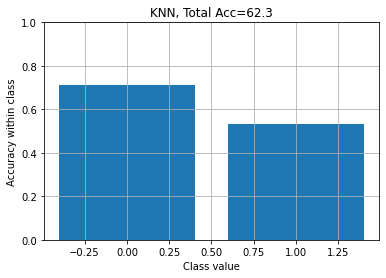

In [79]:
from sklearn.metrics import classification_report
# create variables we are more familiar with
X = XlogR
y = ylogR.astype('int32')
yhat = np.zeros(y.shape).astype('int32') # we will fill this with predictions

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)


# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv_object_log_reg.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

#Generate report for KNN
print(classification_report(y, yhat))

#Build up accuracy within class plot
total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN accuracy', total_accuracy)
plot_class_acc(y,yhat,title="KNN")

### Classification Model #2: Random Forest

              precision    recall  f1-score   support

           0       0.72      0.73      0.72     29072
           1       0.72      0.72      0.72     29072

    accuracy                           0.72     58144
   macro avg       0.72      0.72      0.72     58144
weighted avg       0.72      0.72      0.72     58144

Accuracy 0.7234280407264722


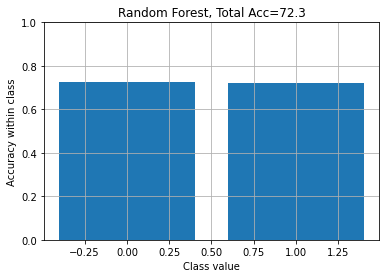

RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1,
                       oob_score=True, random_state=45)


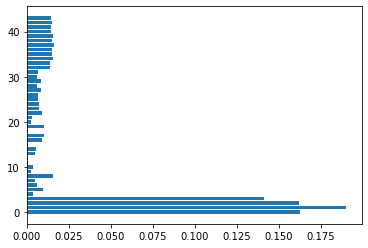

Generalization score estimate from training data 0.7482317531978931
CPU times: user 3min 18s, sys: 5.71 s, total: 3min 23s
Wall time: 30.6 s


In [101]:
%%time
from sklearn.ensemble import RandomForestClassifier

#Build up RF classifier
clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True, random_state=45)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv_object_log_reg.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

#Generate classification report    
print(classification_report(y, yhat))    

#Prepare class accuracy plot
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest")
print (clf)


### Classification Model #3: Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.61      0.73      0.67     29072
           1       0.66      0.54      0.60     29072

    accuracy                           0.63     58144
   macro avg       0.64      0.63      0.63     58144
weighted avg       0.64      0.63      0.63     58144

Accuracy 0.6336853329664281


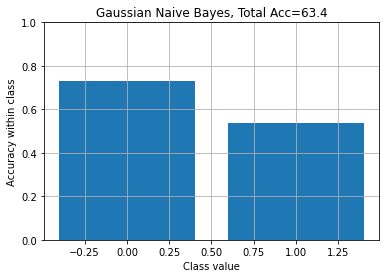

In [127]:
#Although we set this up as a widget, there are no parameters available to tune here!

#Build up NB model
clf3 = GaussianNB()

#now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv_object_log_reg.split(X,y):
    clf3.fit(X[train],y[train])
    yhat[test] = clf3.predict(X[test])

#Print a report on scores for model
print(classification_report(y, yhat)) 

#Setup class accuracy plot
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Gaussian Naive Bayes")

|Model |  Accuracy | Precision |
| --- | --- | --- |
| KNN  | 62.3% | 63% | 
| Random Forest | 72.3% | 72% | 
| Gaussian Naive Bayes | 63.4% | 64% | 


A quick glance shows that according to our metric of classification success, the Random Forest classifier comes cloest to meeting our requirments, unfortunately the model falls slightly short of our 0.8% accuracy.  And none of the models meet our metric. 

With that said, the visuals tell a compelling story.  We can see that each model perfroms better than randomly guessing if a flight will be delayed or not.  KNN comes in with the lowest accuracy at 62.3%, and does slightly better than a random binary guess.  Gaussian Naive Bayes' performance is similar, although slightly better at 63.4%.  Random forest comes in at 72.3%.

Each of the models are useful and can help us gain insight on "on_time_arrival".  Despite the random forest classifer performing the best, computational time is an issue and for slightly less accuracy gaussian naive bayes can be run almost instantly.  

The plots help us visualize that for each classifer, the within class accuracy. With the exception of random forest, the models more accurately capture the 0 class (on-time-arrival).  This shows that the classifers can help someone who is interested in seeing if a given flight will be ontime given a set of inputs than if a flight is delayed (ever so slighly so).  

# Modeling and Evaluation 5

# Modeling and Evaluation 6

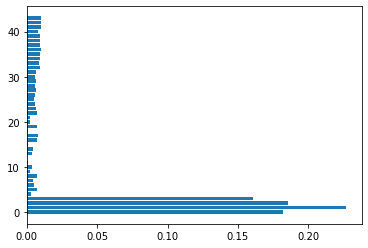

Generalization score estimate from training data 0.7010793054903801


In [136]:
#Plot feature importances
plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()
print ('Generalization score estimate from training data', clf.oob_score_)

# Deployment


## How useful is our model for interested parties?

This model has an appliation for two parties; air travelers and airlines.  

To address air travelers, our model can be useful in several ways.  The model can be used to evaluate an airlines overall ability to generally deliver passengers to their destination in the promised amount of time.  Furthermore, passengers can use this model to look at the different airlines, origins, and time of year to help determine the likelyhood of their flight arriving at its destination on time.  The classification model can be used to tell a passenger if, given a set of inputs for their flight, their flight will classify as on time or not.  The regression model can be used to determine how late their arriving flight will be given a set of inputs like airline, delay type, and time of year.  

To address airlines, our model can be useful in several ways.  Airlines can use this model to look at where, when, and how certain flights from origins end up arrving at their destinations delayed.  They can use this information to update their schedules and work on their operational reliability in terms of delivering passengers in the promised time slot.  Airlines can use the classification model to investiate which flights arrive late, and with that information they can dig deeper into the causes of those arrival delays.  The airlines can use the regression models to determine which delay types are most impactful on getting aircraft to their destinations in a timely fashion (The outcome is delay length, a good question they could as is, "what is the most impactful delay type (security,weather, NAS), that causes our flights to arrive late?).  They can also use this model to investiagte seasonality of delays and investigate questions like, "Are weather delays longer during winter months?" Or "Does do NAS delays occur more often in summertime?"

## How would we deploy our models?

We belive that this model could be deployed into a production environment of an airlines scheduling opeartions center.  The airline could create the new proposed schedule and run it through the classification model and look at which flights have high potential to not arrive on time.  They could then use our regression model to look at seasonality and how a delay would impact the ability for a flight to arrive on time.

This model can also be used on the consumer side to help consumers make informed decisions about which flights to take.  Maybe they have a very important meeting and want to see if they can make their meeting given that for example their United flight has a carrier or weather delay.  

## What other data should be collected?

We feel that the data collected is more than adequate.  If we could add one variable we would like to see the inclusion of aircraft type as this could shed some light on questions like, are larger aircraft more often arriving late? Or are smaller aircraft more asscoiated with carrier delays.




## How often does the model need to be updated?

Ideally this model would be updated yearly as the DOT releases its yearly statistics for the airline industry.  This task could almost certainly be automated and integrated into the rest of the data.  This process is a solid way to update the data since the variables or collection metrics will not change over time as they all need to be captured to evaluate airlines.  

# Exceptional Work

Section not required due to team size